# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

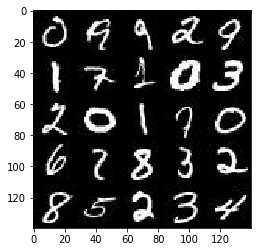

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

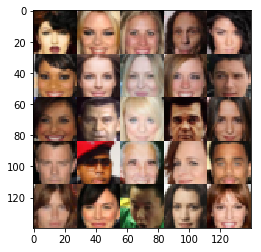

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    # The constant used in the leaky ReLU activation function.
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # The discriminator is inspired by the DCGAN architecture. Batch normalization is
        # used on all layers except the first convolutional layer and the output layer.
        # Shape of images: 28x28x3 (CelebA) or 28x28x1 (MNIST)
        
        # Resulting shape: 14x14x64
        x1 = tf.layers.conv2d(images, 64, 5, 2, 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        
        # Resulting shape: 7x7x128
        x2 = tf.layers.conv2d(x1, 128, 5, 2, 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # Resulting shape: 4x4x256
        # Note: According to the TensorFlow documentation, a ceiling operator
        # is applied to the output width and height when using SAME padding.
        # That's why the width and height of 7 are downscaled to 4.
        # See https://www.tensorflow.org/api_guides/python/nn#Convolution.
        x3 = tf.layers.conv2d(x2, 256, 5, 2, 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(inputs=flat, units=1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # The constant used in the leaky ReLU activation function.
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # Resulting shape: 7x7x512
        x1 = tf.layers.dense(inputs=z, units=7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # Resulting shape: 14x14x256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, 'same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
                
        # Resulting shape: 28x28x128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Resulting shape: 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 1, 'same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    # The label smoothing factor used to help the discriminator generalize better.
    smooth = 0.1

    # The generator output.
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # The discriminator output and logits when fed the real and fake images.
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the discriminator loss.
    # ---------------------------------
    # For real images, the labels are all ones (because they are the real images).
    d_labels_real = tf.ones_like(d_model_real) * (1 - smooth)
    d_cross_entropy_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real)
    d_loss_real = tf.reduce_mean(d_cross_entropy_real)
    
    # For fake images, the labels are all zeros (because they are the fake images).
    d_lables_fake = tf.zeros_like(d_model_fake) * (1 - smooth)
    d_cross_entroy_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_lables_fake)
    d_loss_fake = tf.reduce_mean(d_cross_entroy_fake)
    
    # Calculate the total loss.
    d_loss = d_loss_real + d_loss_fake
    
    # Calculate the generator loss.
    # -----------------------------
    # Remember, the generator is trying to fool the discriminator into outputting
    # ones for fake images. That's why the labels are set to all ones for the fake output.
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and biases to update, separately for the discriminator and the generator.
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Run the optimizer on the respective discriminator and generator variables.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print("data_shape={}".format(data_shape))
    print("data_image_mode={}".format(data_image_mode))
    
    # Build the model.
    # ----------------
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    # Train the model.
    # ----------------
    batch_i = 0
    losses = []
    n_images = 25
    show_losses_every = 10
    show_output_every = 50
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_i += 1
                
                # Rescale images from (-0.5, 0.5) to (-1, 1), because we're using the
                # tanh activation function in the generator which has a range of (-1, 1).
                batch_images = batch_images * 2
                
                # Sample random noise for the generator.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run the optimizers on both the discriminator and the generator.
                # Note: We need to pass the values for the placeholders 'input_real'
                # and 'lr' to the optimizer for the generator to satisfy TensorFlow.
                # They aren't actually used.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                # Print losses.
                if batch_i % show_losses_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Batch {}...".format(batch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                # Print generator output.
                if batch_i % show_output_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
            print("Batches per epoch: {}".format(batch_i))    
            
        show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
        
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape=(60000, 28, 28, 1)
data_image_mode=L
Epoch 1/2... Batch 10... Discriminator Loss: 0.3943... Generator Loss: 5.2802
Epoch 1/2... Batch 20... Discriminator Loss: 0.3380... Generator Loss: 6.3375
Epoch 1/2... Batch 30... Discriminator Loss: 0.3678... Generator Loss: 5.3189
Epoch 1/2... Batch 40... Discriminator Loss: 1.5674... Generator Loss: 4.4487
Epoch 1/2... Batch 50... Discriminator Loss: 0.4147... Generator Loss: 5.5402


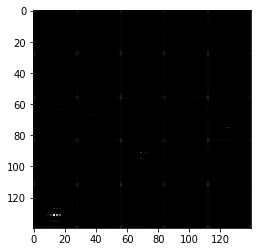

Epoch 1/2... Batch 60... Discriminator Loss: 0.6682... Generator Loss: 1.7905
Epoch 1/2... Batch 70... Discriminator Loss: 0.5803... Generator Loss: 5.7210
Epoch 1/2... Batch 80... Discriminator Loss: 0.4850... Generator Loss: 3.3393
Epoch 1/2... Batch 90... Discriminator Loss: 0.9099... Generator Loss: 1.2222
Epoch 1/2... Batch 100... Discriminator Loss: 0.8070... Generator Loss: 1.5599


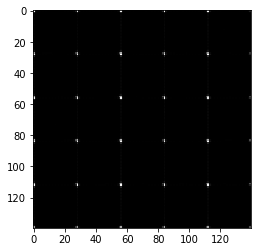

Epoch 1/2... Batch 110... Discriminator Loss: 0.9423... Generator Loss: 1.3339
Epoch 1/2... Batch 120... Discriminator Loss: 1.1065... Generator Loss: 0.9131
Epoch 1/2... Batch 130... Discriminator Loss: 1.2060... Generator Loss: 1.7430
Epoch 1/2... Batch 140... Discriminator Loss: 1.3569... Generator Loss: 2.1942
Epoch 1/2... Batch 150... Discriminator Loss: 1.1011... Generator Loss: 0.8233


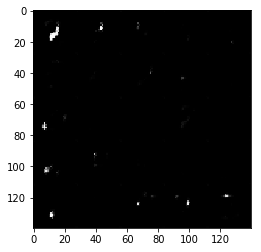

Epoch 1/2... Batch 160... Discriminator Loss: 1.3743... Generator Loss: 3.1534
Epoch 1/2... Batch 170... Discriminator Loss: 1.0881... Generator Loss: 0.8165
Epoch 1/2... Batch 180... Discriminator Loss: 0.7906... Generator Loss: 1.9287
Epoch 1/2... Batch 190... Discriminator Loss: 0.8484... Generator Loss: 1.8186
Epoch 1/2... Batch 200... Discriminator Loss: 1.1126... Generator Loss: 0.8127


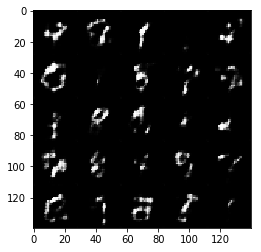

Epoch 1/2... Batch 210... Discriminator Loss: 0.9417... Generator Loss: 1.0613
Epoch 1/2... Batch 220... Discriminator Loss: 0.5142... Generator Loss: 2.3880
Epoch 1/2... Batch 230... Discriminator Loss: 0.8145... Generator Loss: 2.5938
Epoch 1/2... Batch 240... Discriminator Loss: 0.9573... Generator Loss: 3.4337
Epoch 1/2... Batch 250... Discriminator Loss: 0.8046... Generator Loss: 2.7271


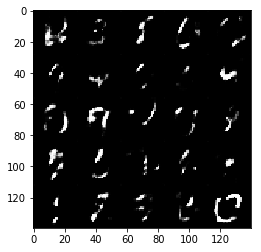

Epoch 1/2... Batch 260... Discriminator Loss: 1.5743... Generator Loss: 3.3246
Epoch 1/2... Batch 270... Discriminator Loss: 1.2461... Generator Loss: 2.1192
Epoch 1/2... Batch 280... Discriminator Loss: 1.1410... Generator Loss: 0.7561
Epoch 1/2... Batch 290... Discriminator Loss: 1.1112... Generator Loss: 1.4777
Epoch 1/2... Batch 300... Discriminator Loss: 1.2668... Generator Loss: 0.7454


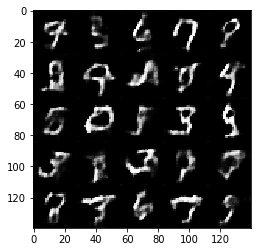

Epoch 1/2... Batch 310... Discriminator Loss: 1.1073... Generator Loss: 1.6258
Epoch 1/2... Batch 320... Discriminator Loss: 1.3220... Generator Loss: 0.5657
Epoch 1/2... Batch 330... Discriminator Loss: 1.1128... Generator Loss: 0.8581
Epoch 1/2... Batch 340... Discriminator Loss: 1.0752... Generator Loss: 1.1497
Epoch 1/2... Batch 350... Discriminator Loss: 1.1359... Generator Loss: 1.0624


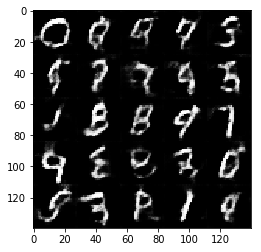

Epoch 1/2... Batch 360... Discriminator Loss: 1.0515... Generator Loss: 1.0784
Epoch 1/2... Batch 370... Discriminator Loss: 1.1321... Generator Loss: 1.0968
Epoch 1/2... Batch 380... Discriminator Loss: 1.1730... Generator Loss: 0.9438
Epoch 1/2... Batch 390... Discriminator Loss: 1.1344... Generator Loss: 0.8420
Epoch 1/2... Batch 400... Discriminator Loss: 1.0996... Generator Loss: 1.3602


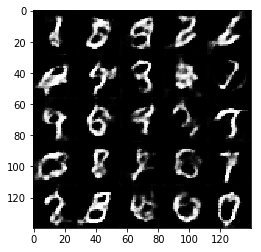

Epoch 1/2... Batch 410... Discriminator Loss: 1.1042... Generator Loss: 0.9378
Epoch 1/2... Batch 420... Discriminator Loss: 1.2405... Generator Loss: 0.6772
Epoch 1/2... Batch 430... Discriminator Loss: 1.2045... Generator Loss: 1.6344
Epoch 1/2... Batch 440... Discriminator Loss: 1.1299... Generator Loss: 1.6438
Epoch 1/2... Batch 450... Discriminator Loss: 0.9903... Generator Loss: 1.3280


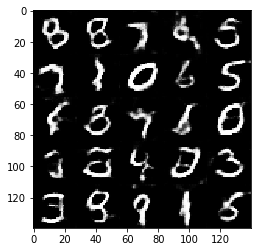

Epoch 1/2... Batch 460... Discriminator Loss: 1.4273... Generator Loss: 0.5825
Batches per epoch: 468
Epoch 2/2... Batch 470... Discriminator Loss: 1.0927... Generator Loss: 1.4511
Epoch 2/2... Batch 480... Discriminator Loss: 1.0329... Generator Loss: 1.0259
Epoch 2/2... Batch 490... Discriminator Loss: 1.0032... Generator Loss: 1.0454
Epoch 2/2... Batch 500... Discriminator Loss: 0.9882... Generator Loss: 1.1174


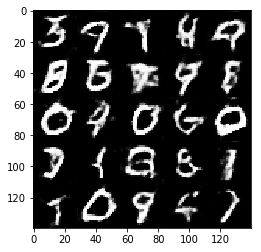

Epoch 2/2... Batch 510... Discriminator Loss: 1.8693... Generator Loss: 2.5326
Epoch 2/2... Batch 520... Discriminator Loss: 1.1093... Generator Loss: 0.8933
Epoch 2/2... Batch 530... Discriminator Loss: 1.0916... Generator Loss: 0.9367
Epoch 2/2... Batch 540... Discriminator Loss: 1.1461... Generator Loss: 0.7829
Epoch 2/2... Batch 550... Discriminator Loss: 1.0873... Generator Loss: 0.8247


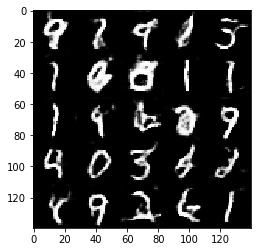

Epoch 2/2... Batch 560... Discriminator Loss: 1.5410... Generator Loss: 2.0377
Epoch 2/2... Batch 570... Discriminator Loss: 0.9712... Generator Loss: 1.3091
Epoch 2/2... Batch 580... Discriminator Loss: 1.1094... Generator Loss: 0.8642
Epoch 2/2... Batch 590... Discriminator Loss: 1.7076... Generator Loss: 0.3999
Epoch 2/2... Batch 600... Discriminator Loss: 1.1750... Generator Loss: 0.8802


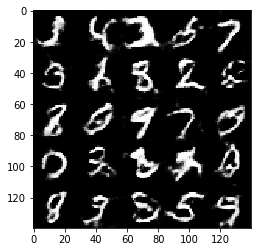

Epoch 2/2... Batch 610... Discriminator Loss: 1.1653... Generator Loss: 1.6043
Epoch 2/2... Batch 620... Discriminator Loss: 1.0856... Generator Loss: 1.1229
Epoch 2/2... Batch 630... Discriminator Loss: 1.1074... Generator Loss: 1.0741
Epoch 2/2... Batch 640... Discriminator Loss: 2.4180... Generator Loss: 0.2193
Epoch 2/2... Batch 650... Discriminator Loss: 1.0336... Generator Loss: 1.1933


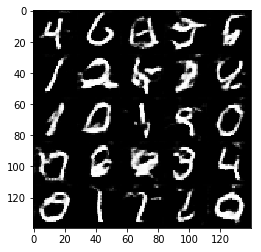

Epoch 2/2... Batch 660... Discriminator Loss: 1.0017... Generator Loss: 1.4176
Epoch 2/2... Batch 670... Discriminator Loss: 1.1108... Generator Loss: 0.8064
Epoch 2/2... Batch 680... Discriminator Loss: 1.0880... Generator Loss: 0.9881
Epoch 2/2... Batch 690... Discriminator Loss: 1.5096... Generator Loss: 0.4259
Epoch 2/2... Batch 700... Discriminator Loss: 1.0775... Generator Loss: 2.0004


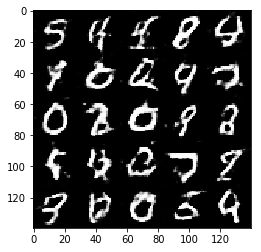

Epoch 2/2... Batch 710... Discriminator Loss: 1.0237... Generator Loss: 0.9567
Epoch 2/2... Batch 720... Discriminator Loss: 1.1396... Generator Loss: 1.0253
Epoch 2/2... Batch 730... Discriminator Loss: 0.9989... Generator Loss: 1.2942
Epoch 2/2... Batch 740... Discriminator Loss: 0.9813... Generator Loss: 1.2544
Epoch 2/2... Batch 750... Discriminator Loss: 1.5997... Generator Loss: 0.5388


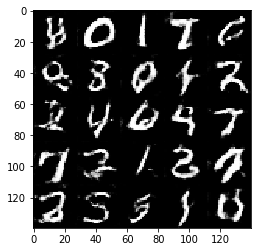

Epoch 2/2... Batch 760... Discriminator Loss: 1.2511... Generator Loss: 0.8415
Epoch 2/2... Batch 770... Discriminator Loss: 1.2237... Generator Loss: 0.7531
Epoch 2/2... Batch 780... Discriminator Loss: 1.0711... Generator Loss: 1.1989
Epoch 2/2... Batch 790... Discriminator Loss: 1.1090... Generator Loss: 0.8284
Epoch 2/2... Batch 800... Discriminator Loss: 1.2999... Generator Loss: 0.5839


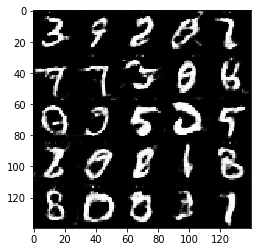

Epoch 2/2... Batch 810... Discriminator Loss: 1.1705... Generator Loss: 0.7147
Epoch 2/2... Batch 820... Discriminator Loss: 1.2212... Generator Loss: 1.6907
Epoch 2/2... Batch 830... Discriminator Loss: 1.1278... Generator Loss: 0.7906
Epoch 2/2... Batch 840... Discriminator Loss: 0.9626... Generator Loss: 1.3783
Epoch 2/2... Batch 850... Discriminator Loss: 1.0778... Generator Loss: 0.8018


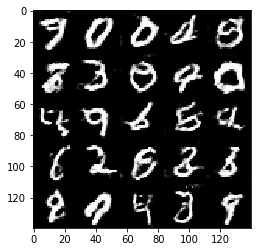

Epoch 2/2... Batch 860... Discriminator Loss: 1.0918... Generator Loss: 0.7984
Epoch 2/2... Batch 870... Discriminator Loss: 1.3296... Generator Loss: 1.6044
Epoch 2/2... Batch 880... Discriminator Loss: 1.0561... Generator Loss: 1.0780
Epoch 2/2... Batch 890... Discriminator Loss: 1.0781... Generator Loss: 1.1858
Epoch 2/2... Batch 900... Discriminator Loss: 1.0103... Generator Loss: 1.1011


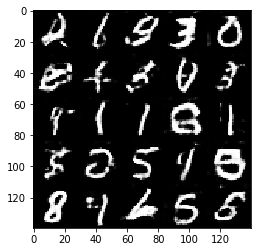

Epoch 2/2... Batch 910... Discriminator Loss: 1.0609... Generator Loss: 1.0019
Epoch 2/2... Batch 920... Discriminator Loss: 1.1734... Generator Loss: 0.6965
Epoch 2/2... Batch 930... Discriminator Loss: 1.1249... Generator Loss: 0.7715
Batches per epoch: 936


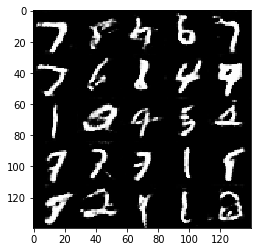

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses_mnist = train(epochs, batch_size, z_dim, learning_rate, beta1, 
                         mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

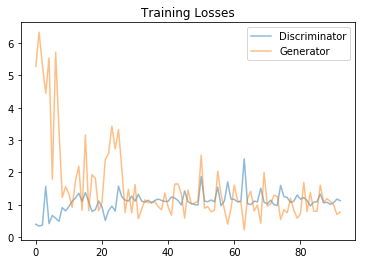

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

losses_mnist = np.array(losses_mnist)
plt.plot(losses_mnist.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_mnist.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape=(202599, 28, 28, 3)
data_image_mode=RGB
Epoch 1/1... Batch 10... Discriminator Loss: 0.4855... Generator Loss: 2.5191
Epoch 1/1... Batch 20... Discriminator Loss: 1.2121... Generator Loss: 0.5958
Epoch 1/1... Batch 30... Discriminator Loss: 0.3905... Generator Loss: 7.8609
Epoch 1/1... Batch 40... Discriminator Loss: 0.6246... Generator Loss: 1.8150
Epoch 1/1... Batch 50... Discriminator Loss: 0.4833... Generator Loss: 3.6232


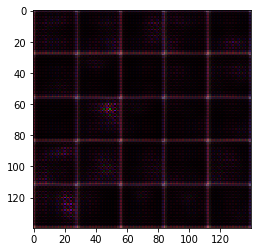

Epoch 1/1... Batch 60... Discriminator Loss: 3.2898... Generator Loss: 9.5008
Epoch 1/1... Batch 70... Discriminator Loss: 2.0988... Generator Loss: 0.3470
Epoch 1/1... Batch 80... Discriminator Loss: 0.6637... Generator Loss: 1.9991
Epoch 1/1... Batch 90... Discriminator Loss: 1.3226... Generator Loss: 0.6588
Epoch 1/1... Batch 100... Discriminator Loss: 0.6167... Generator Loss: 3.5230


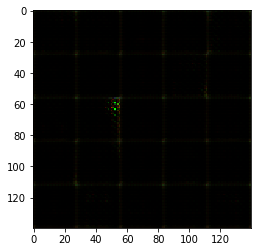

Epoch 1/1... Batch 110... Discriminator Loss: 0.4157... Generator Loss: 4.8502
Epoch 1/1... Batch 120... Discriminator Loss: 0.5389... Generator Loss: 2.0410
Epoch 1/1... Batch 130... Discriminator Loss: 2.9932... Generator Loss: 0.3763
Epoch 1/1... Batch 140... Discriminator Loss: 0.8829... Generator Loss: 1.3277
Epoch 1/1... Batch 150... Discriminator Loss: 1.0849... Generator Loss: 1.9208


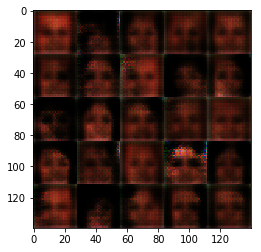

Epoch 1/1... Batch 160... Discriminator Loss: 1.0361... Generator Loss: 1.0894
Epoch 1/1... Batch 170... Discriminator Loss: 1.4337... Generator Loss: 0.6174
Epoch 1/1... Batch 180... Discriminator Loss: 0.8860... Generator Loss: 1.1624
Epoch 1/1... Batch 190... Discriminator Loss: 1.4508... Generator Loss: 2.5695
Epoch 1/1... Batch 200... Discriminator Loss: 1.7029... Generator Loss: 2.7570


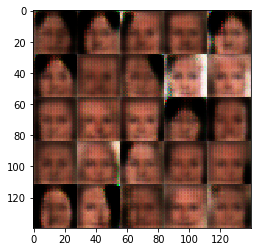

Epoch 1/1... Batch 210... Discriminator Loss: 1.1138... Generator Loss: 0.8372
Epoch 1/1... Batch 220... Discriminator Loss: 1.2633... Generator Loss: 1.5722
Epoch 1/1... Batch 230... Discriminator Loss: 1.1910... Generator Loss: 1.1043
Epoch 1/1... Batch 240... Discriminator Loss: 0.9870... Generator Loss: 1.2352
Epoch 1/1... Batch 250... Discriminator Loss: 1.5338... Generator Loss: 0.5503


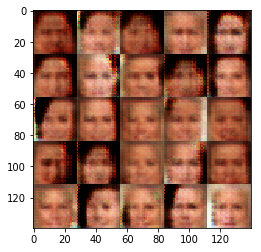

Epoch 1/1... Batch 260... Discriminator Loss: 1.1509... Generator Loss: 1.6540
Epoch 1/1... Batch 270... Discriminator Loss: 0.9863... Generator Loss: 1.0032
Epoch 1/1... Batch 280... Discriminator Loss: 1.0642... Generator Loss: 1.5384
Epoch 1/1... Batch 290... Discriminator Loss: 0.8492... Generator Loss: 1.9023
Epoch 1/1... Batch 300... Discriminator Loss: 1.2161... Generator Loss: 2.2413


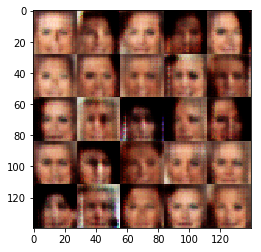

Epoch 1/1... Batch 310... Discriminator Loss: 0.7891... Generator Loss: 1.3230
Epoch 1/1... Batch 320... Discriminator Loss: 1.3339... Generator Loss: 0.9830
Epoch 1/1... Batch 330... Discriminator Loss: 1.5204... Generator Loss: 1.0080
Epoch 1/1... Batch 340... Discriminator Loss: 1.4108... Generator Loss: 0.7971
Epoch 1/1... Batch 350... Discriminator Loss: 1.2115... Generator Loss: 0.8558


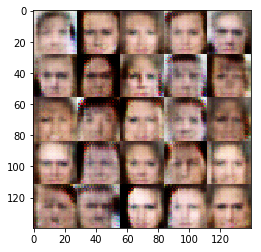

Epoch 1/1... Batch 360... Discriminator Loss: 1.1941... Generator Loss: 1.3879
Epoch 1/1... Batch 370... Discriminator Loss: 0.9298... Generator Loss: 1.7273
Epoch 1/1... Batch 380... Discriminator Loss: 0.6402... Generator Loss: 1.8445
Epoch 1/1... Batch 390... Discriminator Loss: 1.2301... Generator Loss: 1.3967
Epoch 1/1... Batch 400... Discriminator Loss: 0.8389... Generator Loss: 1.5671


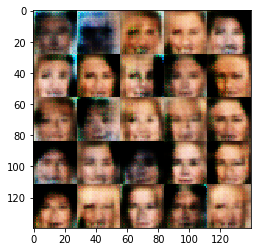

Epoch 1/1... Batch 410... Discriminator Loss: 1.1548... Generator Loss: 0.8075
Epoch 1/1... Batch 420... Discriminator Loss: 1.0698... Generator Loss: 1.1097
Epoch 1/1... Batch 430... Discriminator Loss: 1.3786... Generator Loss: 0.8879
Epoch 1/1... Batch 440... Discriminator Loss: 1.1724... Generator Loss: 0.8180
Epoch 1/1... Batch 450... Discriminator Loss: 1.2462... Generator Loss: 0.7919


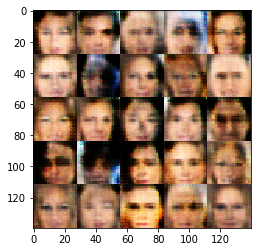

Epoch 1/1... Batch 460... Discriminator Loss: 0.9873... Generator Loss: 1.1502
Epoch 1/1... Batch 470... Discriminator Loss: 1.0638... Generator Loss: 1.2959
Epoch 1/1... Batch 480... Discriminator Loss: 1.2206... Generator Loss: 1.3726
Epoch 1/1... Batch 490... Discriminator Loss: 1.0859... Generator Loss: 0.9739
Epoch 1/1... Batch 500... Discriminator Loss: 1.2727... Generator Loss: 1.1604


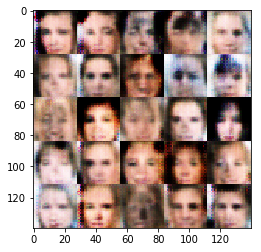

Epoch 1/1... Batch 510... Discriminator Loss: 1.3312... Generator Loss: 0.9631
Epoch 1/1... Batch 520... Discriminator Loss: 1.1228... Generator Loss: 1.0413
Epoch 1/1... Batch 530... Discriminator Loss: 1.5811... Generator Loss: 0.4436
Epoch 1/1... Batch 540... Discriminator Loss: 1.4564... Generator Loss: 1.9818
Epoch 1/1... Batch 550... Discriminator Loss: 0.9854... Generator Loss: 0.9488


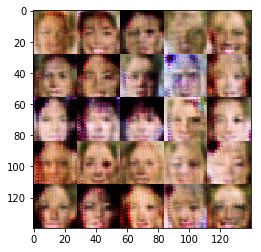

Epoch 1/1... Batch 560... Discriminator Loss: 1.2034... Generator Loss: 0.8668
Epoch 1/1... Batch 570... Discriminator Loss: 1.2679... Generator Loss: 0.6133
Epoch 1/1... Batch 580... Discriminator Loss: 1.2367... Generator Loss: 1.1574
Epoch 1/1... Batch 590... Discriminator Loss: 1.4454... Generator Loss: 0.8668
Epoch 1/1... Batch 600... Discriminator Loss: 1.0718... Generator Loss: 1.4811


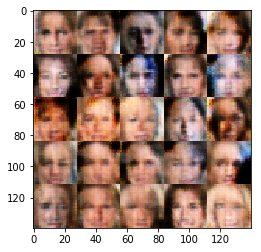

Epoch 1/1... Batch 610... Discriminator Loss: 1.3537... Generator Loss: 1.2049
Epoch 1/1... Batch 620... Discriminator Loss: 1.0504... Generator Loss: 0.8925
Epoch 1/1... Batch 630... Discriminator Loss: 1.2794... Generator Loss: 0.8420
Epoch 1/1... Batch 640... Discriminator Loss: 0.7371... Generator Loss: 1.7834
Epoch 1/1... Batch 650... Discriminator Loss: 1.7722... Generator Loss: 1.9149


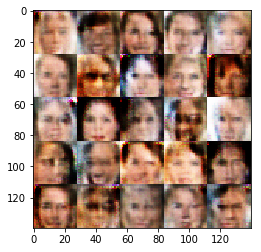

Epoch 1/1... Batch 660... Discriminator Loss: 1.3896... Generator Loss: 0.5709
Epoch 1/1... Batch 670... Discriminator Loss: 1.2036... Generator Loss: 1.3056
Epoch 1/1... Batch 680... Discriminator Loss: 1.1051... Generator Loss: 1.1064
Epoch 1/1... Batch 690... Discriminator Loss: 1.1959... Generator Loss: 1.0134
Epoch 1/1... Batch 700... Discriminator Loss: 1.0895... Generator Loss: 0.9758


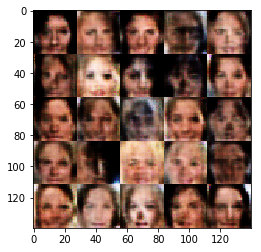

Epoch 1/1... Batch 710... Discriminator Loss: 1.2089... Generator Loss: 0.8050
Epoch 1/1... Batch 720... Discriminator Loss: 1.3190... Generator Loss: 1.2011
Epoch 1/1... Batch 730... Discriminator Loss: 1.6030... Generator Loss: 2.1834
Epoch 1/1... Batch 740... Discriminator Loss: 1.2194... Generator Loss: 0.9252
Epoch 1/1... Batch 750... Discriminator Loss: 1.0500... Generator Loss: 2.1894


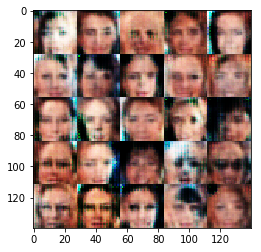

Epoch 1/1... Batch 760... Discriminator Loss: 0.9224... Generator Loss: 1.8472
Epoch 1/1... Batch 770... Discriminator Loss: 1.5545... Generator Loss: 0.4125
Epoch 1/1... Batch 780... Discriminator Loss: 1.3957... Generator Loss: 0.6158
Epoch 1/1... Batch 790... Discriminator Loss: 1.2276... Generator Loss: 0.7519
Epoch 1/1... Batch 800... Discriminator Loss: 1.0301... Generator Loss: 1.1753


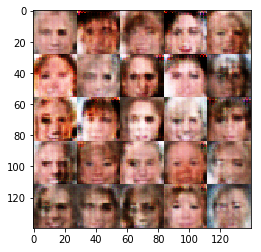

Epoch 1/1... Batch 810... Discriminator Loss: 1.4942... Generator Loss: 0.4776
Epoch 1/1... Batch 820... Discriminator Loss: 1.1372... Generator Loss: 0.7055
Epoch 1/1... Batch 830... Discriminator Loss: 1.6781... Generator Loss: 1.8812
Epoch 1/1... Batch 840... Discriminator Loss: 1.0684... Generator Loss: 0.8763
Epoch 1/1... Batch 850... Discriminator Loss: 1.6774... Generator Loss: 2.2679


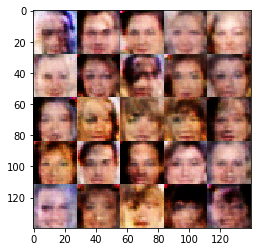

Epoch 1/1... Batch 860... Discriminator Loss: 1.1417... Generator Loss: 1.2121
Epoch 1/1... Batch 870... Discriminator Loss: 1.2667... Generator Loss: 0.7205
Epoch 1/1... Batch 880... Discriminator Loss: 1.2209... Generator Loss: 1.1282
Epoch 1/1... Batch 890... Discriminator Loss: 1.2350... Generator Loss: 0.8459
Epoch 1/1... Batch 900... Discriminator Loss: 1.2025... Generator Loss: 1.9438


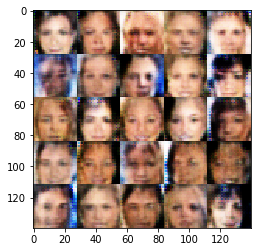

Epoch 1/1... Batch 910... Discriminator Loss: 1.2257... Generator Loss: 0.9152
Epoch 1/1... Batch 920... Discriminator Loss: 1.4239... Generator Loss: 0.5496
Epoch 1/1... Batch 930... Discriminator Loss: 1.3473... Generator Loss: 0.5165
Epoch 1/1... Batch 940... Discriminator Loss: 1.0761... Generator Loss: 1.0067
Epoch 1/1... Batch 950... Discriminator Loss: 1.3892... Generator Loss: 0.9101


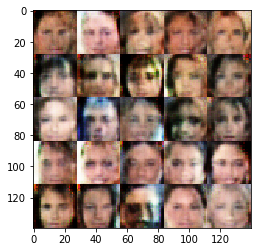

Epoch 1/1... Batch 960... Discriminator Loss: 0.9478... Generator Loss: 1.1312
Epoch 1/1... Batch 970... Discriminator Loss: 1.3448... Generator Loss: 1.0021
Epoch 1/1... Batch 980... Discriminator Loss: 1.2456... Generator Loss: 0.6668
Epoch 1/1... Batch 990... Discriminator Loss: 2.5026... Generator Loss: 2.5583
Epoch 1/1... Batch 1000... Discriminator Loss: 1.2674... Generator Loss: 1.2712


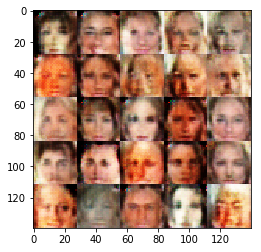

Epoch 1/1... Batch 1010... Discriminator Loss: 0.9649... Generator Loss: 1.6520
Epoch 1/1... Batch 1020... Discriminator Loss: 1.2687... Generator Loss: 0.7725
Epoch 1/1... Batch 1030... Discriminator Loss: 1.0088... Generator Loss: 1.0391
Epoch 1/1... Batch 1040... Discriminator Loss: 1.2249... Generator Loss: 0.9308
Epoch 1/1... Batch 1050... Discriminator Loss: 1.3083... Generator Loss: 0.6918


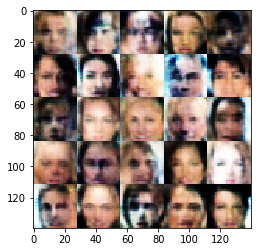

Epoch 1/1... Batch 1060... Discriminator Loss: 1.4528... Generator Loss: 1.4942
Epoch 1/1... Batch 1070... Discriminator Loss: 1.2479... Generator Loss: 0.7508
Epoch 1/1... Batch 1080... Discriminator Loss: 1.4975... Generator Loss: 0.4348
Epoch 1/1... Batch 1090... Discriminator Loss: 1.3677... Generator Loss: 0.5793
Epoch 1/1... Batch 1100... Discriminator Loss: 1.1421... Generator Loss: 1.0450


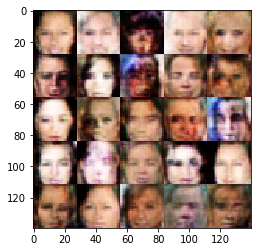

Epoch 1/1... Batch 1110... Discriminator Loss: 1.2462... Generator Loss: 1.0433
Epoch 1/1... Batch 1120... Discriminator Loss: 1.6657... Generator Loss: 0.3554
Epoch 1/1... Batch 1130... Discriminator Loss: 1.3279... Generator Loss: 0.8123
Epoch 1/1... Batch 1140... Discriminator Loss: 1.4052... Generator Loss: 0.5501
Epoch 1/1... Batch 1150... Discriminator Loss: 1.1516... Generator Loss: 0.8180


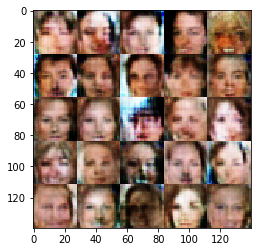

Epoch 1/1... Batch 1160... Discriminator Loss: 1.4746... Generator Loss: 0.6580
Epoch 1/1... Batch 1170... Discriminator Loss: 1.4219... Generator Loss: 1.1282
Epoch 1/1... Batch 1180... Discriminator Loss: 1.4737... Generator Loss: 0.4479
Epoch 1/1... Batch 1190... Discriminator Loss: 1.3065... Generator Loss: 0.5801
Epoch 1/1... Batch 1200... Discriminator Loss: 1.3418... Generator Loss: 0.5629


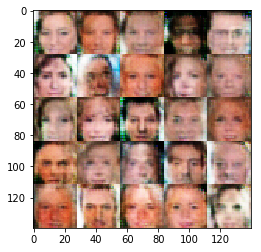

Epoch 1/1... Batch 1210... Discriminator Loss: 1.0525... Generator Loss: 1.1948
Epoch 1/1... Batch 1220... Discriminator Loss: 1.3572... Generator Loss: 0.5921
Epoch 1/1... Batch 1230... Discriminator Loss: 1.3202... Generator Loss: 0.6781
Epoch 1/1... Batch 1240... Discriminator Loss: 1.1947... Generator Loss: 1.5650
Epoch 1/1... Batch 1250... Discriminator Loss: 1.2008... Generator Loss: 1.0719


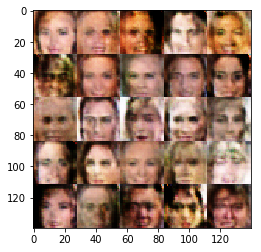

Epoch 1/1... Batch 1260... Discriminator Loss: 1.2614... Generator Loss: 0.7169
Epoch 1/1... Batch 1270... Discriminator Loss: 1.3569... Generator Loss: 0.7651
Epoch 1/1... Batch 1280... Discriminator Loss: 1.1583... Generator Loss: 0.9489
Epoch 1/1... Batch 1290... Discriminator Loss: 1.3033... Generator Loss: 0.7076
Epoch 1/1... Batch 1300... Discriminator Loss: 1.2002... Generator Loss: 0.7385


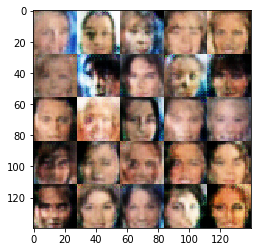

Epoch 1/1... Batch 1310... Discriminator Loss: 1.3492... Generator Loss: 0.6608
Epoch 1/1... Batch 1320... Discriminator Loss: 1.4487... Generator Loss: 1.2940
Epoch 1/1... Batch 1330... Discriminator Loss: 1.3787... Generator Loss: 1.4595
Epoch 1/1... Batch 1340... Discriminator Loss: 1.6333... Generator Loss: 1.8769
Epoch 1/1... Batch 1350... Discriminator Loss: 1.3934... Generator Loss: 0.6804


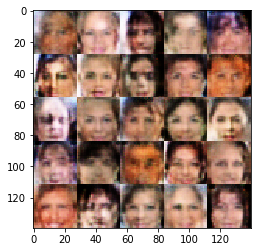

Epoch 1/1... Batch 1360... Discriminator Loss: 1.3147... Generator Loss: 1.3902
Epoch 1/1... Batch 1370... Discriminator Loss: 0.8451... Generator Loss: 1.1531
Epoch 1/1... Batch 1380... Discriminator Loss: 1.2945... Generator Loss: 0.8253
Epoch 1/1... Batch 1390... Discriminator Loss: 1.3135... Generator Loss: 0.8812
Epoch 1/1... Batch 1400... Discriminator Loss: 1.4556... Generator Loss: 1.0438


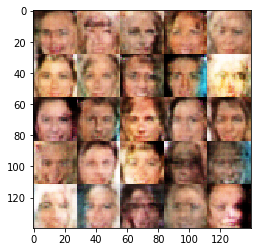

Epoch 1/1... Batch 1410... Discriminator Loss: 1.2037... Generator Loss: 1.0528
Epoch 1/1... Batch 1420... Discriminator Loss: 1.3413... Generator Loss: 1.0493
Epoch 1/1... Batch 1430... Discriminator Loss: 1.1997... Generator Loss: 0.7037
Epoch 1/1... Batch 1440... Discriminator Loss: 1.2278... Generator Loss: 1.1090
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2272... Generator Loss: 0.6811


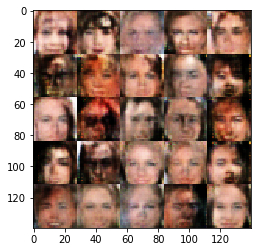

Epoch 1/1... Batch 1460... Discriminator Loss: 1.2298... Generator Loss: 1.0868
Epoch 1/1... Batch 1470... Discriminator Loss: 1.3440... Generator Loss: 0.5529
Epoch 1/1... Batch 1480... Discriminator Loss: 1.1690... Generator Loss: 0.8835
Epoch 1/1... Batch 1490... Discriminator Loss: 1.0921... Generator Loss: 1.1690
Epoch 1/1... Batch 1500... Discriminator Loss: 1.0077... Generator Loss: 1.1327


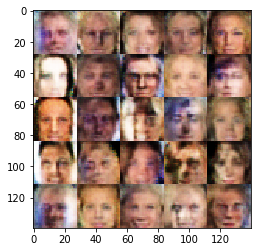

Epoch 1/1... Batch 1510... Discriminator Loss: 2.1522... Generator Loss: 1.7731
Epoch 1/1... Batch 1520... Discriminator Loss: 1.4103... Generator Loss: 0.7547
Epoch 1/1... Batch 1530... Discriminator Loss: 1.4206... Generator Loss: 0.7683
Epoch 1/1... Batch 1540... Discriminator Loss: 1.3828... Generator Loss: 0.8363
Epoch 1/1... Batch 1550... Discriminator Loss: 1.3705... Generator Loss: 0.6336


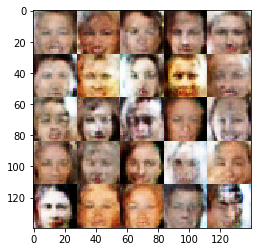

Epoch 1/1... Batch 1560... Discriminator Loss: 1.4578... Generator Loss: 0.5758
Epoch 1/1... Batch 1570... Discriminator Loss: 1.3898... Generator Loss: 0.8738
Epoch 1/1... Batch 1580... Discriminator Loss: 1.1311... Generator Loss: 0.8118
Batches per epoch: 1582


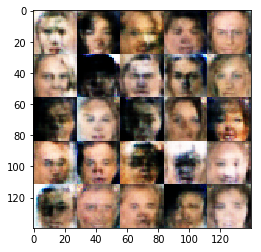

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses_celeba = train(epochs, batch_size, z_dim, learning_rate, beta1,
                          celeba_dataset.get_batches, celeba_dataset.shape, celeba_dataset.image_mode)

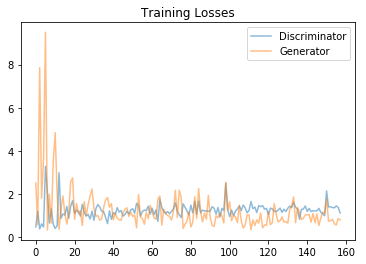

In [15]:
losses_celeba = np.array(losses_celeba)
plt.plot(losses_celeba.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_celeba.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.